In [2]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [6]:
df = pd.read_csv('SeaPlaneTravel.csv')
df.head()

,Month,#Passengers
0,2003-01,112
1,2003-02,118
2,2003-03,132
3,2003-04,129
4,2003-05,121


In [9]:
df['Month'] = pd.to_datetime(df['Month'])
indexed_df = df.set_index('Month')
ts = indexed_df['#Passengers']
ts.head(5)

Month
2003-01-01    112
2003-02-01    118
2003-03-01    132
2003-04-01    129
2003-05-01    121
Name: #Passengers, dtype: int64

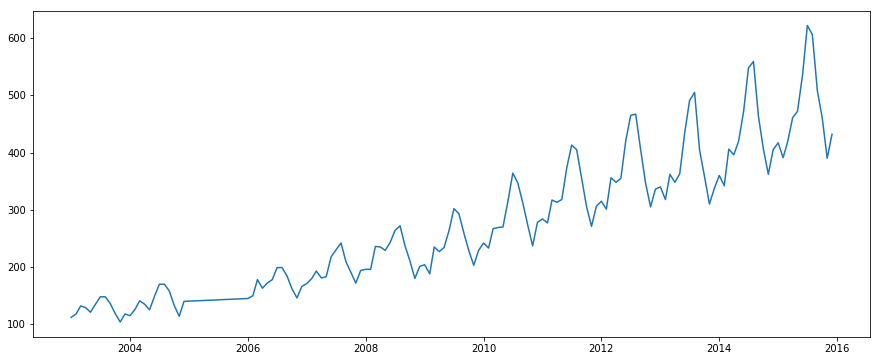

In [11]:
plt.plot(ts)

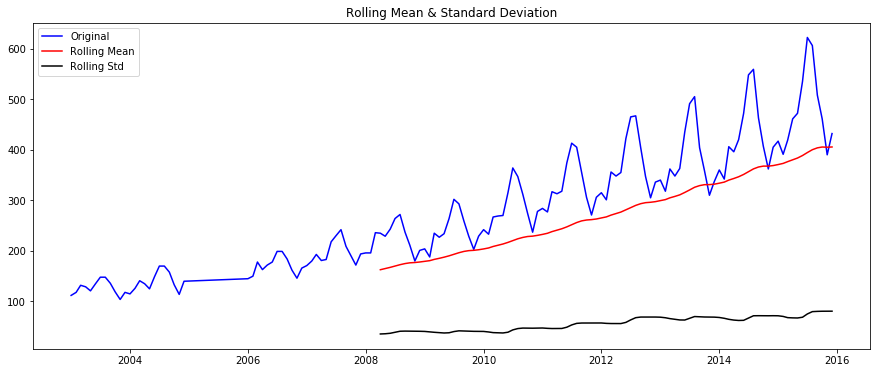

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [15]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(ts)

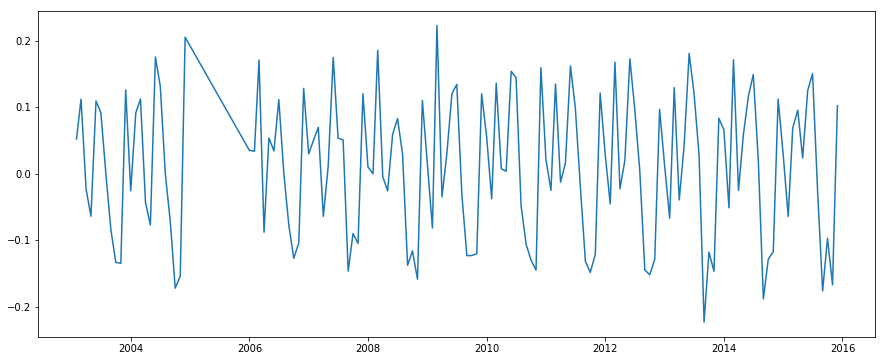

In [17]:
ts_log = np.log(ts)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

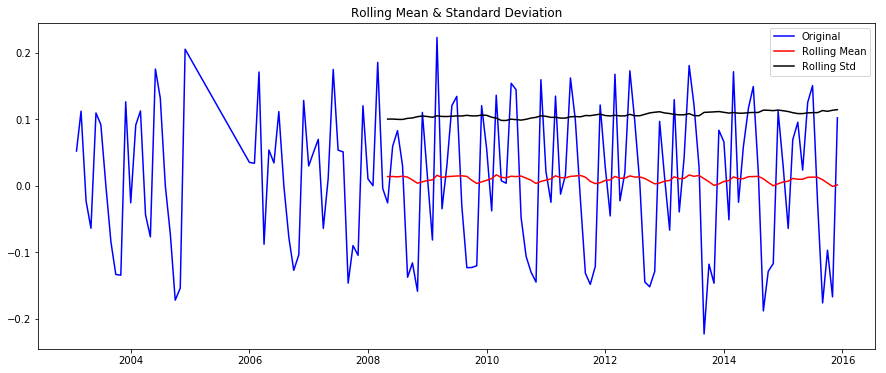

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [19]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [22]:
#ACF and PACF
lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

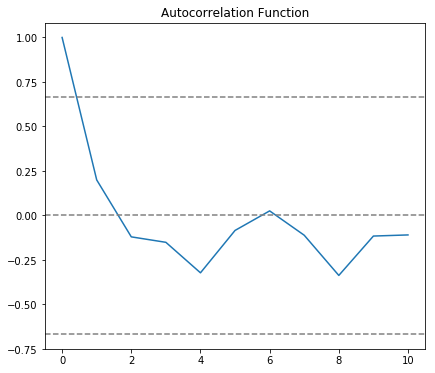

In [25]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

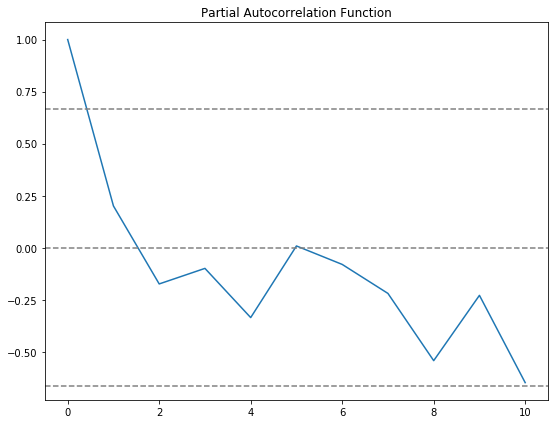

In [27]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

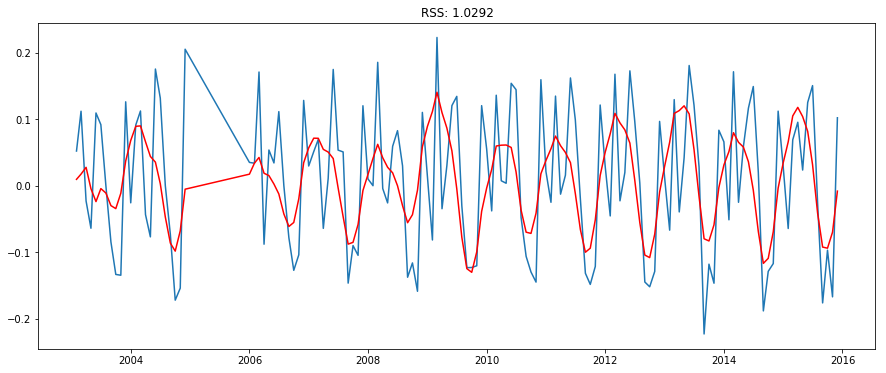

In [31]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 149.640
Method:                       css-mle   S.D. of innovations              0.084
Date:                Sun, 07 Apr 2019   AIC                           -287.281
Time:                        17:05:02   BIC                           -269.504
Sample:                             1   HQIC                          -280.057
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096      0.003      3.697      0.000       0.005       0.015
ar.L1.D.#Passengers     1.6293      0.039     41.868      0.000       1.553       1.706
ar.L2.D.#Passeng

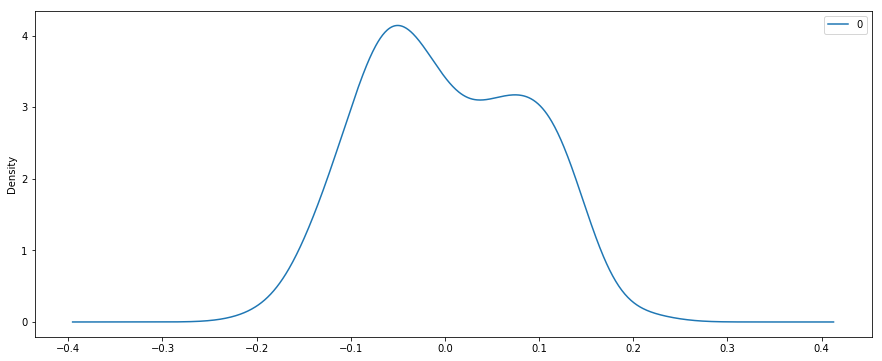

In [33]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [35]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Month
2003-02-01    0.009580
2003-03-01    0.017491
2003-04-01    0.027670
2003-05-01   -0.004521
2003-06-01   -0.023890
dtype: float64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Text(0.5, 1.0, 'RMSE: 90.1046')

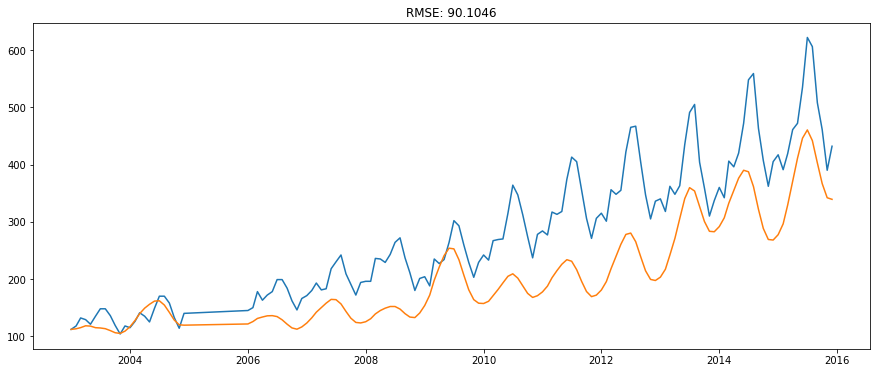

In [40]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [43]:
size = int(len(ts_log) - 15)
train, test = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train]
predictions = list()
print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

Printing Predicted vs Expected Values...




/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=406.222562, expected=432.000000


In [45]:
error = mean_squared_error(test, predictions)
print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)
predictions_series = pd.Series(predictions, index = test.index)



Printing Mean Squared Error of Predictions...
Test MSE: 0.010385


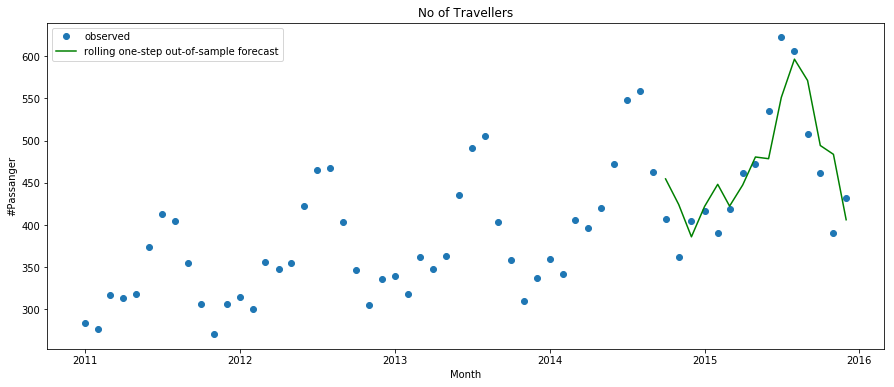

In [49]:
fig, ax = plt.subplots()
ax.set(title='No of Travellers', xlabel='Month', ylabel='#Passanger')
ax.plot(ts[-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')